<a href="https://colab.research.google.com/github/gkar90/COVID-19_X-Ray_Classification/blob/main/COVID_19_vs_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview:

URL: "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"

The Kaggle dataset above shows multiple chest X-rays of patients who either had pneumonia, COVID-19, or no illness at all. 

The hope of this project is to create *Convulutional Neural Networks* using TensorFlow/Keras to properly and accurately predict whether an X-ray image has COVID-19, pneumonia, or nothing at all. 

Some things to note on this project are:


1.   We are using an already pre-processed dataset. The datasets are broken into test and train folders
> Within those folders we have the images already classified as either Normal, COVID-19, or Pneumonia


2.   In order to not bog down the program, we will be running a small amount of neural networks. To properly optimize the model, we could play with various variables (learning rate, epoch sizes, batch sizes)...but for our purposes here, we'll be running small sizes so the program runs quickly. 


## Import Modules

First thing to do is to import all the modules


In [241]:
import tensorflow as tf
from tensorflow import argmax
from tensorflow import expand_dims
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Import Datasets

Now we import the data we'll be working with

In [ ]:
#all modules brought in, now download dataset from Kaggle and create neural network
url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle



/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 94% 149M/158M [00:02<00:00, 78.9MB/s]
100% 158M/158M [00:02<00:00, 74.5MB/s]


In [ ]:
ls

covid19-image-dataset.zip  kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  covid19-image-dataset.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00012.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00022.jpg  
  inflating: Covid1

Great. We have our modules, and we have our dataset.

We're ready now to start our modeling...

## Creating Iterators

First thing we want to do is create a training and a validation iterator

In [ ]:
def iterator(data_generator, directory, class_mode, color_mode, batch_size):
  iterator = data_generator.flow_from_directory(directory,
                                                class_mode = class_mode, 
                                                color_mode = color_mode,
                                                batch_size = batch_size)
  return iterator


In [ ]:
input_data = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
training_iterator = iterator(
    input_data,
    '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/train', 
    'categorical', 
    'grayscale', 
    10)
training_iterator

Found 251 images belonging to 3 classes.


In [ ]:
validation_iterator = creating_iterator(
    input_data,
    '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/test', 
    'categorical', 
    'grayscale', 
    10)
validation_iterator

Found 66 images belonging to 3 classes.


Great. We have both of our iterators, lets see what the image shapes are like.

In [ ]:
def get_training_shape(iterator):
  sample_batch_input, sample_batch_labels = iterator.next()
  shape = sample_batch_input.shape
  # there are 4 numbers output here
  # first number = the number of images per batch
  # second and third number = the size of the images
  # fourth number = the color mode of the images
  return shape[1:]



In [ ]:
input_shape = get_training_shape(training_iterator)
input_shape

(256, 256, 1)

## Creating Our Model

We've got the training and the validation iterators (and necessary information on each)...we can start creating our model now

In [ ]:
def create_model(learning_rate):

  #instantiate the model
  model = Sequential()

  #create the input layer
  model.add(layers.Input(shape = input_shape))

  #add the Convulutional Layer
  model.add(layers.Conv2D(
      2, 
      5, 
      strides = 3,  
      activation='relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (5,5), 
      strides = (5,5),
      ))
  
  #add second convultional and pooling layer
  model.add(layers.Conv2D(
      4,
      3,
      strides = 1,
      activation = 'relu'
  ))

  model.add(layers.MaxPooling2D(
      pool_size = (2, 2),
      strides = (2, 2)
  ))

  # now flatten layers so can pass through a Dense layer
  model.add(layers.Flatten())

  # now add our Dense layers 
  # first our hidden layer
  model.add(layers.Dense(16, activation = 'relu'))

  # now our output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  #now compile
  model.compile(
      loss = losses.CategoricalCrossentropy(),
      metrics = [
                 metrics.CategoricalAccuracy(),
                 metrics.AUC()
      ],
      optimizer = optimizers.Adam(learning_rate = learning_rate)
  )

  return model

In [ ]:
our_model = create_model(0.01)

Perfect. We've created our model with our selected parameters, so let's just see the models summary and see the amount of parameters we're working with

*For our program to run within a reasonable time, we're going to try to keep the parameters <5000*

In [ ]:
def model_summary(model):
  return model.summary()

In [ ]:
model_summary(our_model)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 84, 84, 2)         52        
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 4)         76        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 7, 7, 4)           0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 196)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                3152      
_________________________________________________________________
dense_39 (Dense)             (None, 3)               

## Fit The Model

We've created our model above, now we can run it through our function to fit it.

In [ ]:
def fit_model(model, training_iterator, validation_iterator, batch_size, epoch_size):
  #lets first get out training and validation data generators:


  early_stop = EarlyStopping(
      monitor = 'val_loss',
      patience = 10
  )
  
  print("Training the model. This may take a while...")
  history = model.fit(
      training_iterator, 
      steps_per_epoch = training_iterator.samples/batch_size, 
      epochs = epoch_size, 
      verbose = 1,
      callbacks = [early_stop],
      validation_data = validation_iterator, 
      validation_steps = validation_iterator.samples/batch_size
  )

  return history

In [ ]:
epochs = 100
batch_size = 10
fit_mod = fit_model(our_model, training_iterator, validation_iterator, batch_size, epochs)

Training the model. This may take a while...
Epoch 1/100
25/25 [==============================] - 16s 637ms/step - loss: 1.0840 - categorical_accuracy: 0.3685 - auc_9: 0.5561 - val_loss: 0.9374 - val_categorical_accuracy: 0.6212 - val_auc_9: 0.8174
Epoch 2/100
25/25 [==============================] - 15s 630ms/step - loss: 0.7732 - categorical_accuracy: 0.7157 - auc_9: 0.8750 - val_loss: 0.3282 - val_categorical_accuracy: 0.9394 - val_auc_9: 0.9823
Epoch 3/100
25/25 [==============================] - 15s 626ms/step - loss: 0.4633 - categorical_accuracy: 0.8257 - auc_9: 0.9394 - val_loss: 0.3913 - val_categorical_accuracy: 0.8939 - val_auc_9: 0.9753
Epoch 4/100
25/25 [==============================] - 15s 606ms/step - loss: 0.3994 - categorical_accuracy: 0.8107 - auc_9: 0.9575 - val_loss: 0.3875 - val_categorical_accuracy: 0.8485 - val_auc_9: 0.9545
Epoch 5/100
25/25 [==============================] - 15s 610ms/step - loss: 0.2369 - categorical_accuracy: 0.9138 - auc_9: 0.9840 - val_los

Perfect! We've fit our model, and our early stop worked, stopping our program from continuing because it realized the convergence of the accuracy.

## Vizualize The Model

We can now try to visualize two things from our model:


1.   Compare the X-Rays
> Let's see if we could see what the model compared classified as correct/incorrect and see why it thought that.


2.   Visualize how accurate our model was
> Let's see our accuracy over time (and see at what point our EarlyStop kicked in)





### Visualize the X-Rays

First let's see the images side-by-side

In [ ]:
#Visualizes convolutional layer activations
def visualize_activations(model, validation_iterator):
    #A keras model that will output our previous model's activations for each convolutional layer:
    activation_extractor = Model(
        inputs = model.inputs, 
        outputs = [layer.output for layer in model.layers if "conv2d" in layer.name]
    )

    #Take matplotlib frame and remove axes.
    def clean_plot(plot):
        plot.axes.get_xaxis().set_visible(False)
        plot.axes.get_yaxis().set_visible(False)

    #Dict mapping from class numbers to string labels:
    class_names = {
        0: "Covid",
        1: "Normal",
        2: "Pneumonia"
    }

    #Loads a sample batch of data
    sample_batch_input, sample_labels = validation_iterator.next()
    
    #Grabs the first five images
    sample_batch_input = sample_batch_input[:5]
    sample_labels = sample_labels[:5]

    #Makes predictions using model.predict(x)
    sample_predictions = model.predict(sample_batch_input)

    #Iterate of images, predictions, and true labels
    for i, (image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

        print("""
        ----------------------------
        """)

        image_name = "X_ray #{}".format(i+1)

        #Gets predicted class with highest probability
        predicted_class = argmax(prediction).numpy()

        #Gets correct label
        actual_class = argmax(label).numpy()

        print(image_name)
        print("\tModel prediction: COVID: {}, Normal: {}, Pneumonia: {}".format(prediction[0], prediction[1], prediction[2]))
        print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
        print("\tCorrect:", predicted_class == actual_class)
        print("""
        """)

        #Saves image file using matplotlib
        sample_image = image
        clean_plot(plt.imshow(
            sample_image[:, :, 0],
            cmap = "gray"
        ))
        plt.title(image_name + " Predicted: {},  Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
        plt.tight_layout()
        plt.show()
        model_layer_output = activation_extractor(expand_dims(sample_image, 0))
        
        plt.clf()

        #Iterates over each layer output
        for l_num, output_data in enumerate(model_layer_output):
            #Creates a subplot for each filter
            fig, axs = plt.subplots(1, output_data.shape[-1])
            
            #For each filter
            for i in range(output_data.shape[-1]):
                #Plots the filter's activations
                clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap = "gray"))
        
            plt.suptitle(image_name + " Conv {}".format(l_num), y = 0.6)
            plt.tight_layout()
            plt.show()
            plt.clf()
    


In [ ]:
fit_mod_model = fit_mod.model


        ----------------------------
        
X_ray #1
	Model prediction: COVID: 0.9908587336540222, Normal: 0.0031396374106407166, Pneumonia: 0.006001668516546488
	True label: Covid (0)
	Correct: True

        


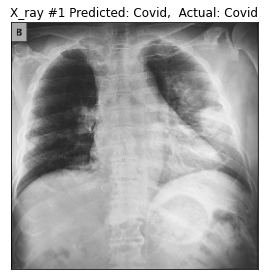

<Figure size 432x288 with 0 Axes>

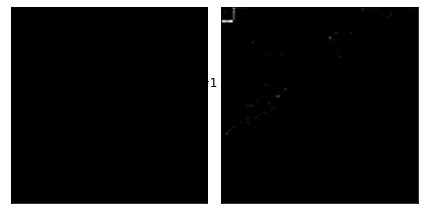

<Figure size 432x288 with 0 Axes>

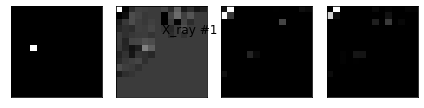


        ----------------------------
        
X_ray #2
	Model prediction: COVID: 6.486385245807469e-06, Normal: 0.8838591575622559, Pneumonia: 0.1161343976855278
	True label: Normal (1)
	Correct: True

        


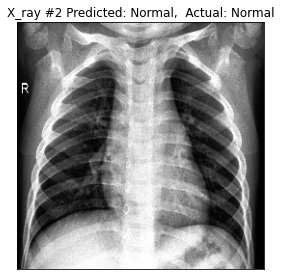

<Figure size 432x288 with 0 Axes>

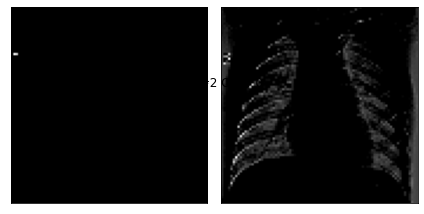

<Figure size 432x288 with 0 Axes>

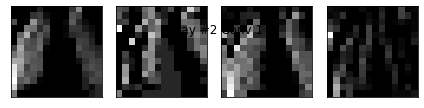


        ----------------------------
        
X_ray #3
	Model prediction: COVID: 2.0785728693795136e-09, Normal: 6.827218021498993e-05, Pneumonia: 0.9999316930770874
	True label: Pneumonia (2)
	Correct: True

        


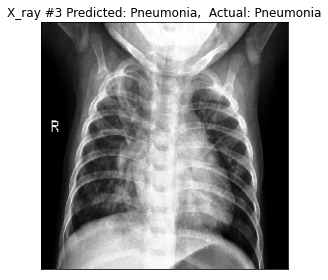

<Figure size 432x288 with 0 Axes>

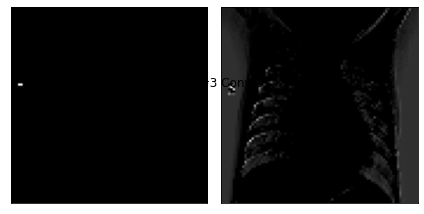

<Figure size 432x288 with 0 Axes>

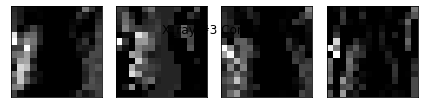


        ----------------------------
        
X_ray #4
	Model prediction: COVID: 0.9756428003311157, Normal: 0.0015445583267137408, Pneumonia: 0.022812670096755028
	True label: Covid (0)
	Correct: True

        


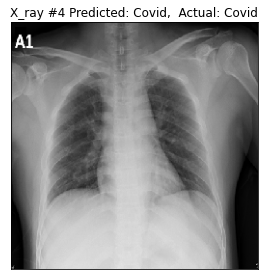

<Figure size 432x288 with 0 Axes>

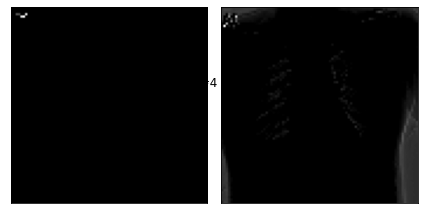

<Figure size 432x288 with 0 Axes>

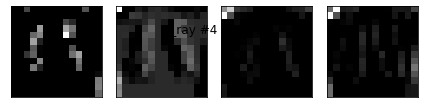


        ----------------------------
        
X_ray #5
	Model prediction: COVID: 4.10814804396864e-09, Normal: 0.9912283420562744, Pneumonia: 0.00877164676785469
	True label: Normal (1)
	Correct: True

        


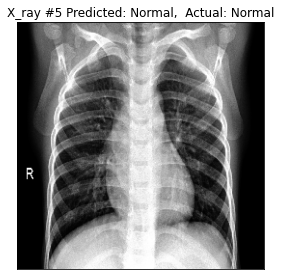

<Figure size 432x288 with 0 Axes>

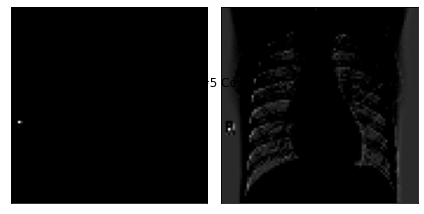

<Figure size 432x288 with 0 Axes>

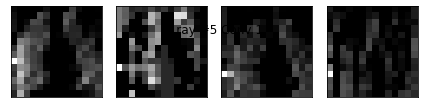

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_activations(fit_mod_model, validation_iterator)

Awesome! We are able to show the first 5 images of our model! We can see the original images, and we can see the images that were output from sending our original input through the different neural networks.

#### Breakdown:


1.   X-rays are seperated by "-----" and are labeled 1-5
2.   Below the label is the models prediction, shown as:
> `COVID %`, `Normal %`, and `Pneumonia %`
3.   The original X-ray with the `Prediction`, and the `Actual` label on top of it
4.   The images as they pass through the filters and convulutional neural network 





### Visualize the Accuracy of the Model

Let's see our model and how accurate it was 

In [ ]:
def visualize_accuracy(history):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # plotting auc and validation auc over epochs
    keys = list(history.history.keys())
    #print(keys)
    #print(keys[2])
    #print(keys[-1])
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history[keys[2]])
    ax2.plot(history.history[keys[-1]])
    ax2.set_title('model auc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

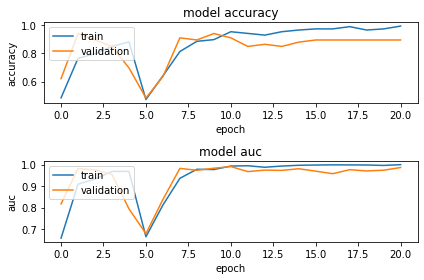

In [ ]:
visualize_accuracy(fit_mod)




## Create Statistical Reports

We've seen the model visually, now lets put some reports out to see the accuracy.

In [255]:
def class_report(validation_iterator):
  test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
  predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = validation_iterator.classes
  class_labels = list(validation_iterator.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)

  print("Our classification report is: ")
  print(report)

In [256]:
def con_matrix(validation_iterator):
  test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
  predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = validation_iterator.classes
  class_labels = list(validation_iterator.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = confusion_matrix(true_classes, predicted_classes)

  print("Our confusion matrix is: ")
  print(cm)


In [257]:
our_classification_report = class_report(validation_iterator)

Our classification report is: 
                 precision    recall  f1-score   support

          Covid       0.48      0.38      0.43        26
         Normal       0.38      0.15      0.21        20
Viral Pneumonia       0.35      0.65      0.46        20

       accuracy                           0.39        66
      macro avg       0.40      0.39      0.37        66
   weighted avg       0.41      0.39      0.37        66



In [258]:
our_conf_matrix = con_matrix(validation_iterator)

Our confusion matrix is: 
[[10  1 15]
 [ 4  2 14]
 [ 7  5  8]]


So we see that our current classification is generally about 40% accurate, which is sadly not great.

In order to get better and more accurate results, some steps we could take are:


1.   Get more data
> The more X-rays we can get, the better our training model will be. the better the training model, the more accurate our predictions will be
2.   Tweak the hyperparameters
> Things we could change are the `learning rate`, the `number of epochs`, the `batch sizes`, and the `various filters` and `strides`. In order to get a better result, we would look to optimize each parameter, and let the computer run and produce a better result. Due to time/computer restraints, this is something that we will leave as is for the time being.
